# Models from scratch

We are gonna run our scratch models here, hypertune them, evaluate them and save the models.

In [ ]:
# importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os 
import joblib

from sklearn.model_selection import RandomizedSearchCV   

# importing custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.data.load_data import load_data

from src.models.MLP_scratch import MLP as MLP_scratch, Trainer as Trainer_scratch
from src.models.DT_scratch import Decision_tree as DT_scratch
from src.utils.tuning import run_random_search
# from src.utils.optimiziers import Adam, SGD, SGDMomentum, Adagrad
# from src.utils.losses import MAE, MSE, Huber, LogCosh
from src.visualization.model_plots import prediction_distribution, parity_plot, residual_plot,  plot_learning_curve




Loading in the `X` features and the specified `y` targets

In [2]:
target = "log_ClaimRate"

(X_train, y_train), (X_test, y_test)= load_data(raw=False, target=target)

## Decision Tree from Scratch

In [4]:
DT = DT_scratch(
    max_depth=5,
    min_samples_split=10,
)


In [5]:
param_grid = {
    "max_depth": [None, 2, 3, 5, 8, 12],
    "min_samples_split": [2, 5, 10, 20, 50]
}


In [6]:
search = run_random_search(DT, param_grid, X_train, y_train, n_iter=50)

/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 

In [7]:
DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)
mse = np.mean((y_test - y_pred)**2)
print(f"Test MSE: {mse}")


Test MSE: 0.10623657589302507


In [ ]:
residual_plot(y_test, y_pred, title="Decision Tree Residual Plot")

## Neural Network from Scratch

We make an instance of our Neural Network class.

In [3]:
MLP = Trainer_scratch(input_dim=X_train.shape[1], 
                      hidden_sizes=[32, 64],
                      model=MLP_scratch,
                      optimizer="adam",
                      loss_fn="mse",
                      epochs=100
                      )

we also need to define our parameter distributions for RandomizedGridSearchCV.

In [4]:
param_dist_MLP = {
    "hidden_sizes": [
        [32, 64], 
        [64, 128], 
        [128, 256],
        [32, 64, 128],
        [64, 128, 256],
        [8, 16, 32, 64],
        [16, 32, 64, 128],
    ],
    "optimizer": ["sgd", "sgd_momentum", "adam", "adagrad"],
    "loss_fn": ["mse", "mae", "huber", "logcosh"],
    "batch_size": [32, 64, 128, 256],
}


And we run the hyperparameter tuning model using Randomized Search, and RMSE as the evaluation metric for 25 iterations.

In [5]:
search = run_random_search(MLP, param_dist_MLP, X_train, y_train, n_iter=25, n_jobs=-1)

Epoch  20 | train_loss=nan
Epoch  20 | train_loss=nan
Epoch  58 | train_loss=0.062188
Epoch  58 | train_loss=0.062532
Epoch  59 | train_loss=0.062860
Epoch  59 | train_loss=0.062151
Epoch  59 | train_loss=0.062527
Epoch  60 | train_loss=0.062891
Epoch  70 | train_loss=nan
Epoch  60 | train_loss=0.062102
Epoch  60 | train_loss=0.062566
Epoch  70 | train_loss=nan
Epoch  61 | train_loss=0.062865
Epoch  70 | train_loss=nan
Epoch  21 | train_loss=nan
Epoch  21 | train_loss=nan
Epoch  61 | train_loss=0.062200
Epoch  61 | train_loss=0.062533
Epoch  62 | train_loss=0.062889
Epoch  62 | train_loss=0.062146
Epoch  62 | train_loss=0.062604
Epoch  63 | train_loss=0.062879
Epoch  71 | train_loss=nan
Epoch  63 | train_loss=0.062237
Epoch  63 | train_loss=0.062548
Epoch  71 | train_loss=nan
Epoch  71 | train_loss=nan
Epoch  64 | train_loss=0.062858
Epoch  22 | train_loss=nan
Epoch  22 | train_loss=nan
Epoch  64 | train_loss=0.062152
Epoch  64 | train_loss=0.062494
Epoch  65 | train_loss=0.062870
Epoc

/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 100 | train_loss=0.062622
[CV 1/5] END batch_size=64, hidden_sizes=[32, 64], loss_fn=mae, optimizer=sgd_momentum;, score=(train=-0.323, test=-0.328) total time=19.8min
Epoch  84 | train_loss=nan
[CV 3/5] END batch_size=64, hidden_sizes=[32, 64], loss_fn=mae, optimizer=sgd_momentum;, score=(train=-0.324, test=-0.324) total time=19.9min
Epoch  84 | train_loss=nan
Epoch  35 | train_loss=nan
Epoch  35 | train_loss=nan
Epoch  84 | train_loss=nan


/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch   1 | train_loss=nan
Epoch   1 | train_loss=0.073961
Epoch   1 | train_loss=0.074134
Epoch  85 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  85 | train_loss=nan
Epoch   2 | train_loss=0.064735
Epoch   2 | train_loss=0.064426
Epoch  36 | train_loss=nan
Epoch  36 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  85 | train_loss=nan
Epoch   4 | train_loss=nan
Epoch   3 | train_loss=0.063353
Epoch   3 | train_loss=0.063070
Epoch   5 | train_loss=nan
Epoch   4 | train_loss=0.062863
Epoch   4 | train_loss=0.062673
Epoch   6 | train_loss=nan
Epoch  86 | train_loss=nan
Epoch  86 | train_loss=nan
Epoch   7 | train_loss=nan
Epoch   5 | train_loss=0.062630
Epoch   5 | train_loss=0.062411
Epoch  37 | train_loss=nan
Epoch  37 | train_loss=nan
Epoch  86 | train_loss=nan
Epoch   8 | train_loss=nan
Epoch   6 | train_loss=0.062492
Epoch   6 | train_loss=0.062355
Epoch   9 | train_loss=nan
Epoch  10 | train_loss=nan
Epoch   7 | train_loss=0.062462
Epoch   7 | train_loss=0.062259
Epoch  87 | 

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[CV 1/5] END batch_size=128, hidden_sizes=[64, 128, 256], loss_fn=huber, optimizer=sgd;, score=(train=-0.317, test=-0.322) total time=36.7min
Epoch  55 | train_loss=nan
Epoch  55 | train_loss=nan


/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  89 | train_loss=nan


/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch   1 | train_loss=nan
Epoch  58 | train_loss=0.062392
Epoch  58 | train_loss=0.062520
Epoch   1 | train_loss=nan
Epoch  90 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  59 | train_loss=0.062422
Epoch   2 | train_loss=nan
Epoch  91 | train_loss=nan
Epoch  59 | train_loss=0.062572
Epoch   3 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  92 | train_loss=nan
Epoch   4 | train_loss=nan
Epoch  60 | train_loss=0.062378
Epoch   4 | train_loss=nan
Epoch  60 | train_loss=0.062508
Epoch  56 | train_loss=nan
Epoch   4 | train_loss=nan
Epoch  93 | train_loss=nan
Epoch  56 | train_loss=nan
Epoch   5 | train_loss=nan
Epoch   5 | train_loss=nan
Epoch   5 | train_loss=nan
Epoch  94 | train_loss=nan
Epoch  61 | train_loss=0.062400
Epoch   6 | train_loss=nan
Epoch  61 | train_loss=0.062602
Epoch   6 | train_loss=nan
Epoch   6 | train_loss=nan
Epoch  95 | train_loss=nan
Epoch   7 | train_loss=nan
Epoch   7 | tra

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  13 | train_loss=nan
Epoch  66 | train_loss=0.062479
Epoch  58 | train_loss=nan
Epoch  66 | train_loss=0.062537
Epoch  58 | train_loss=nan
Epoch  13 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch  14 | train_loss=nan
Epoch  14 | train_loss=nan
Epoch  14 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  15 | train_loss=nan
Epoch  67 | train_loss=0.062394
Epoch  67 | train_loss=0.062604
Epoch  15 | train_loss=nan
Epoch  15 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  16 | train_loss=nan
Epoch  16 | train_loss=nan
Epoch  68 | train_loss=0.062457
Epoch  68 | train_loss=0.062606
Epoch  16 | train_loss=nan
Epoch   4 | train_loss=nan
Epoch  17 | train_loss=nan
Epoch  17 | train_loss=nan
Epoch  17 | train_loss=nan
Epoch   5 | train_loss=nan
Epoch  18 | train_loss=nan
Epoch  59 | train_loss=nan
Epoch  59 | train_loss=nan
Epoch  69 | train_loss=0.062422
Epoch  69 | train_loss=0.062592
Epoch  18 | train_loss=nan
Epoch  18 | train_loss=nan
Epoch   6 | train_loss=nan
Epoch  19 | tra

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  22 | train_loss=0.100200
Epoch  40 | train_loss=0.063852
Epoch  46 | train_loss=0.100356
Epoch  28 | train_loss=0.100018
Epoch   1 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  55 | train_loss=0.099272
Epoch  42 | train_loss=0.063889
Epoch  27 | train_loss=0.100156
Epoch  23 | train_loss=0.100184
Epoch   3 | train_loss=nan
Epoch  47 | train_loss=0.100347
Epoch  29 | train_loss=0.100006
Epoch  41 | train_loss=0.063792
Epoch   4 | train_loss=nan
Epoch  56 | train_loss=0.099264
Epoch  28 | train_loss=0.100143
Epoch   5 | train_loss=nan
Epoch  24 | train_loss=0.100168
Epoch  48 | train_loss=0.100338
Epoch  30 | train_loss=0.099994
Epoch  43 | train_loss=0.063845
Epoch   6 | train_loss=nan
Epoch   7 | train_loss=nan
Epoch  57 | train_loss=0.099256
Epoch  42 | train_loss=0.063733
Epoch  29 | train_loss=0.100130
Epoch  25 | train_loss=0.100153
Epoch  49 | train_loss=0.100328
Epoch   8 | train_loss=nan
Epoch  31 | train_loss=0.099983
Epoch   9 | train_loss=nan
Epoch  44 | train_los

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  70 | train_loss=0.062873
Epoch   1 | train_loss=nan
Epoch  96 | train_loss=0.099013
Epoch  88 | train_loss=0.100053
Epoch  64 | train_loss=0.099749
Epoch   2 | train_loss=nan
Epoch  70 | train_loss=0.099708
Epoch  68 | train_loss=0.099752
Epoch  72 | train_loss=0.062995
Epoch   3 | train_loss=nan
Epoch  97 | train_loss=0.099008
Epoch   4 | train_loss=nan
Epoch  89 | train_loss=0.100047
Epoch  71 | train_loss=0.062849
Epoch  65 | train_loss=0.099742
Epoch  71 | train_loss=0.099703
Epoch  69 | train_loss=0.099745
Epoch   5 | train_loss=nan
Epoch   6 | train_loss=nan
Epoch  73 | train_loss=0.062980
Epoch  98 | train_loss=0.099003
Epoch  90 | train_loss=0.100042
Epoch  66 | train_loss=0.099736
Epoch   7 | train_loss=nan
Epoch  72 | train_loss=0.099697
Epoch  70 | train_loss=0.099738
Epoch  72 | train_loss=0.062839
Epoch   8 | train_loss=nan
Epoch  99 | train_loss=0.098998
Epoch   9 | train_loss=nan
Epoch  91 | train_loss=0.100036
Epoch  67 | train_loss=0.099729
Epoch  74 | train_los

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  73 | train_loss=0.099719
Epoch  16 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch  76 | train_loss=0.062934
Epoch  94 | train_loss=0.100020
Epoch  17 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  70 | train_loss=0.099710
Epoch  76 | train_loss=0.099676
Epoch  74 | train_loss=0.099713
Epoch  18 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  75 | train_loss=0.062792
Epoch  19 | train_loss=nan
Epoch   4 | train_loss=nan
Epoch  95 | train_loss=0.100015
Epoch  71 | train_loss=0.099704
Epoch  77 | train_loss=0.099671
Epoch  20 | train_loss=nan
Epoch   5 | train_loss=nan
Epoch  77 | train_loss=0.062919
Epoch  75 | train_loss=0.099707
Epoch  21 | train_loss=nan
Epoch   6 | train_loss=nan
Epoch  76 | train_loss=0.062779
Epoch  96 | train_loss=0.100009
Epoch  22 | train_loss=nan
Epoch   7 | train_loss=nan
Epoch  72 | train_loss=0.099697
Epoch  78 | train_loss=0.099666
Epoch  76 | train_loss=0.099701
Epoch  23 | train_loss=nan
Epoch   8 | train_loss=nan
Epoch  78 | train_loss=0

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  81 | train_loss=0.099672
Epoch  80 | train_loss=0.062723
Epoch  36 | train_loss=nan
Epoch  21 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch  37 | train_loss=nan
Epoch  22 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  78 | train_loss=0.099662
Epoch  82 | train_loss=0.062856
Epoch  84 | train_loss=0.099634
Epoch  38 | train_loss=nan
Epoch  82 | train_loss=0.099666
Epoch  23 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  39 | train_loss=nan
Epoch  81 | train_loss=0.062712
Epoch  24 | train_loss=nan
Epoch   4 | train_loss=nan
Epoch  40 | train_loss=nan
Epoch  79 | train_loss=0.099656
Epoch  85 | train_loss=0.099628
Epoch   5 | train_loss=nan
Epoch  25 | train_loss=nan
Epoch  83 | train_loss=0.099661
Epoch  41 | train_loss=nan
Epoch  83 | train_loss=0.062846
Epoch   6 | train_loss=nan
Epoch  26 | train_loss=nan
Epoch  42 | train_loss=nan
Epoch   7 | train_loss=nan
Epoch  27 | train_loss=nan
Epoch  80 | train_loss=0.099651
Epoch  86 | train_loss=0.099623
Epoch  82 | train

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  46 | train_loss=nan
Epoch  66 | train_loss=nan
Epoch  82 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch  47 | train_loss=nan
Epoch  95 | train_loss=0.062725
Epoch  96 | train_loss=0.099567
Epoch  67 | train_loss=nan
Epoch  83 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  48 | train_loss=nan
Epoch 100 | train_loss=0.099575
Epoch  68 | train_loss=nan
Epoch  84 | train_loss=nan
Epoch  49 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  94 | train_loss=0.062577
Epoch  69 | train_loss=nan
Epoch  85 | train_loss=nan
Epoch  50 | train_loss=nan
Epoch   4 | train_loss=nan
Epoch  97 | train_loss=0.099562
Epoch  70 | train_loss=nan
Epoch  86 | train_loss=nan
[CV 4/5] END batch_size=256, hidden_sizes=[128, 256], loss_fn=mse, optimizer=sgd_momentum;, score=(train=-0.315, test=-0.315) total time=19.1min
Epoch  96 | train_loss=0.062717
Epoch  51 | train_loss=nan
Epoch   5 | train_loss=nan


/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  71 | train_loss=nan
Epoch  87 | train_loss=nan
Epoch  52 | train_loss=nan
Epoch   6 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch  95 | train_loss=0.062568
Epoch  98 | train_loss=0.099557
Epoch  72 | train_loss=nan
Epoch  88 | train_loss=nan
Epoch  53 | train_loss=nan
Epoch   7 | train_loss=nan
Epoch  73 | train_loss=nan
Epoch  89 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  54 | train_loss=nan
Epoch   8 | train_loss=nan
Epoch  97 | train_loss=0.062708
Epoch  74 | train_loss=nan
Epoch  90 | train_loss=nan
Epoch  55 | train_loss=nan
Epoch   9 | train_loss=nan
Epoch  99 | train_loss=0.099552
Epoch   3 | train_loss=nan
Epoch  75 | train_loss=nan
Epoch  91 | train_loss=nan
Epoch  56 | train_loss=nan
Epoch  10 | train_loss=nan
Epoch  96 | train_loss=0.062559
Epoch  92 | train_loss=nan
Epoch  76 | train_loss=nan
Epoch   4 | train_loss=nan
Epoch  57 | train_loss=nan
Epoch  11 | train_loss=nan
Epoch 100 | train_loss=0.099547
Epoch  93 | train_loss=nan
Epoch  77 | train_loss=na

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  61 | train_loss=nan
Epoch  15 | train_loss=nan
Epoch   7 | train_loss=nan
Epoch  99 | train_loss=0.062693
Epoch  97 | train_loss=nan
Epoch  81 | train_loss=nan
Epoch  62 | train_loss=nan
Epoch  16 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch   8 | train_loss=nan
Epoch  98 | train_loss=nan
Epoch  82 | train_loss=nan
Epoch  63 | train_loss=nan
Epoch  98 | train_loss=0.062543
Epoch  17 | train_loss=nan
Epoch  99 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  83 | train_loss=nan
Epoch  64 | train_loss=nan
Epoch   9 | train_loss=nan
Epoch  18 | train_loss=nan
Epoch 100 | train_loss=nan
Epoch 100 | train_loss=0.062683
Epoch  84 | train_loss=nan
Epoch  65 | train_loss=nan
Epoch  19 | train_loss=nan
Epoch   3 | train_loss=nan
[CV 2/5] END batch_size=128, hidden_sizes=[8, 16, 32, 64], loss_fn=huber, optimizer=sgd;, score=(train=-0.319, test=-0.315) total time= 7.5min
Epoch  10 | train_loss=nan
Epoch  85 | train_loss=nan
Epoch  66 | train_loss=nan


/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  20 | train_loss=nan
Epoch  99 | train_loss=0.062534
Epoch   4 | train_loss=nan
Epoch  86 | train_loss=nan
Epoch  67 | train_loss=nan
Epoch  11 | train_loss=nan
Epoch  21 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch  87 | train_loss=nan
Epoch  68 | train_loss=nan
[CV 4/5] END batch_size=64, hidden_sizes=[128, 256], loss_fn=mae, optimizer=sgd;, score=(train=-0.324, test=-0.323) total time=26.2min
Epoch  22 | train_loss=nan
Epoch   5 | train_loss=nan


/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  12 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  88 | train_loss=nan
Epoch  69 | train_loss=nan
Epoch  23 | train_loss=nan
Epoch   6 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch 100 | train_loss=0.062529
Epoch  70 | train_loss=nan
Epoch  13 | train_loss=nan
Epoch  89 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  24 | train_loss=nan
Epoch  90 | train_loss=nan
Epoch  71 | train_loss=nan
Epoch   7 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  25 | train_loss=nan
Epoch  14 | train_loss=nan
Epoch   4 | train_loss=nan
Epoch  91 | train_loss=nan
Epoch  72 | train_loss=nan
Epoch  26 | train_loss=nan
Epoch   8 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  15 | train_loss=nan
Epoch  73 | train_loss=nan
Epoch   5 | train_loss=nan
Epoch  92 | train_loss=nan
Epoch  27 | train_loss=nan
[CV 5/5] END batch_size=64, hidden_sizes=[128, 256], loss_fn=mae, optimizer=sgd;, score=(train=-0.324, test=-0.323) total time=26.3min


/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  74 | train_loss=nan
Epoch   4 | train_loss=nan
Epoch  93 | train_loss=nan
Epoch   9 | train_loss=nan
Epoch  16 | train_loss=nan
Epoch  28 | train_loss=nan
Epoch   6 | train_loss=nan
Epoch  75 | train_loss=nan
Epoch  94 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch  29 | train_loss=nan
Epoch   5 | train_loss=nan
Epoch  10 | train_loss=nan
Epoch  17 | train_loss=nan
Epoch   7 | train_loss=nan
Epoch  76 | train_loss=nan
Epoch  95 | train_loss=nan
Epoch  30 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch   6 | train_loss=nan
Epoch  11 | train_loss=nan
Epoch  77 | train_loss=nan
Epoch  96 | train_loss=nan
Epoch  18 | train_loss=nan
Epoch  31 | train_loss=nan
Epoch   8 | train_loss=nan
Epoch  78 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  97 | train_loss=nan
Epoch  32 | train_loss=nan
Epoch   7 | train_loss=nan
Epoch  12 | train_loss=nan
Epoch  19 | train_loss=nan
Epoch   9 | train_loss=nan
Epoch  79 | train_loss=nan
Epoch  98 | train_loss=nan
Epoch  33 | train_loss=nan
E

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:23: RuntimeWarning: Mean of empty slice.
  0.5 * (diff[quad] ** 2).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()


[CV 4/5] END batch_size=256, hidden_sizes=[32, 64, 128], loss_fn=huber, optimizer=adam;, score=(train=-0.313, test=-0.320) total time=11.4min


/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:23: RuntimeWarning: Mean of empty slice.
  0.5 * (diff[quad] ** 2).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()


Epoch  97 | train_loss=nan
Epoch   2 | train_loss=0.081360
Epoch  23 | train_loss=0.063091
Epoch  40 | train_loss=0.062905
Epoch  98 | train_loss=nan
Epoch   6 | train_loss=0.066856
Epoch  46 | train_loss=0.062185
Epoch  99 | train_loss=nan
Epoch   3 | train_loss=0.074135
Epoch  24 | train_loss=0.062907
Epoch  41 | train_loss=0.062986
Epoch 100 | train_loss=nan
Epoch   7 | train_loss=0.066221
Epoch  47 | train_loss=0.062154
[CV 5/5] END batch_size=256, hidden_sizes=[32, 64, 128], loss_fn=huber, optimizer=adam;, score=(train=-0.313, test=-0.319) total time=11.4min
Epoch   4 | train_loss=0.070993
Epoch  25 | train_loss=0.062894
Epoch  42 | train_loss=0.063098
Epoch   1 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch   8 | train_loss=0.064833


/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:23: RuntimeWarning: Mean of empty slice.
  0.5 * (diff[quad] ** 2).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()


Epoch  48 | train_loss=0.062179
Epoch   5 | train_loss=0.068583
Epoch  26 | train_loss=0.062863
Epoch  43 | train_loss=0.062988
Epoch   9 | train_loss=0.064633
Epoch  49 | train_loss=0.062225
Epoch   6 | train_loss=0.067287
Epoch  27 | train_loss=0.062908
Epoch  44 | train_loss=0.063000
Epoch  10 | train_loss=0.064759
Epoch  50 | train_loss=0.062225
Epoch   2 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch   7 | train_loss=0.065555
Epoch   1 | train_loss=nan
Epoch  28 | train_loss=0.062799
Epoch  45 | train_loss=0.062983
Epoch  11 | train_loss=0.064365
Epoch  51 | train_loss=0.062180
Epoch   8 | train_loss=0.065202
Epoch  29 | train_loss=0.062874
Epoch  46 | train_loss=0.062925
Epoch  12 | train_loss=0.064119
Epoch  52 | train_loss=0.062064
Epoch   9 | train_loss=0.064454
Epoch  30 | train_loss=0.062791
Epoch  47 | train_loss=0.062893
Epoch   3 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  13 | train_loss=0.063792
Epoch   2 | train_loss=nan
Epoch  53 | train_loss=0.062172
Epoch 

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:23: RuntimeWarning: Mean of empty slice.
  0.5 * (diff[quad] ** 2).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()


Epoch  62 | train_loss=0.062518
Epoch  96 | train_loss=0.062982
Epoch  59 | train_loss=0.062452
Epoch  80 | train_loss=0.062542
Epoch  22 | train_loss=nan
Epoch  23 | train_loss=nan
Epoch  63 | train_loss=0.062589
Epoch  97 | train_loss=0.062780
Epoch  60 | train_loss=0.062296
Epoch  81 | train_loss=0.062502
Epoch  23 | train_loss=nan
Epoch  64 | train_loss=0.062531
Epoch  98 | train_loss=0.062834
Epoch   1 | train_loss=nan
Epoch  61 | train_loss=0.062390
Epoch  82 | train_loss=0.062418
Epoch  65 | train_loss=0.062547
Epoch  23 | train_loss=nan
Epoch  99 | train_loss=0.062820
Epoch  24 | train_loss=nan
Epoch  83 | train_loss=0.062331
Epoch  62 | train_loss=0.062419
Epoch  66 | train_loss=0.062602
Epoch 100 | train_loss=0.062894
Epoch  24 | train_loss=nan
Epoch  84 | train_loss=0.062479
Epoch  63 | train_loss=0.062425
Epoch  67 | train_loss=0.062544
Epoch   2 | train_loss=nan
[CV 2/5] END batch_size=256, hidden_sizes=[64, 128, 256], loss_fn=mae, optimizer=sgd_momentum;, score=(train=-0.

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:23: RuntimeWarning: Mean of empty slice.
  0.5 * (diff[quad] ** 2).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()


Epoch  85 | train_loss=0.062432
Epoch  24 | train_loss=nan
Epoch  64 | train_loss=0.062422
Epoch  25 | train_loss=nan
Epoch  68 | train_loss=0.062569
Epoch  86 | train_loss=0.062543
Epoch  65 | train_loss=0.062382
Epoch  25 | train_loss=nan
Epoch  69 | train_loss=0.062476
Epoch  87 | train_loss=0.062547
Epoch  66 | train_loss=0.062368
Epoch   3 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch  70 | train_loss=0.062591
Epoch  25 | train_loss=nan
Epoch  26 | train_loss=nan
Epoch  88 | train_loss=0.062503
Epoch  67 | train_loss=0.062426
Epoch  71 | train_loss=0.062359
Epoch  26 | train_loss=nan
Epoch  89 | train_loss=0.062499
Epoch  68 | train_loss=0.062425
Epoch  72 | train_loss=0.062454
Epoch   4 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  90 | train_loss=0.062536
Epoch  26 | train_loss=nan
Epoch  69 | train_loss=0.062368
Epoch  27 | train_loss=nan
Epoch  73 | train_loss=0.062499
Epoch  91 | train_loss=0.062473
Epoch  70 | train_loss=0.062359
Epoch  27 | train_loss=nan
Epoch  74

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  64 | train_loss=0.032679
Epoch  87 | train_loss=0.062538
Epoch  82 | train_loss=0.032447
Epoch   7 | train_loss=0.062415
Epoch   1 | train_loss=nan
Epoch  88 | train_loss=0.062658
Epoch  78 | train_loss=0.032830
Epoch   8 | train_loss=0.062336
Epoch   2 | train_loss=nan
Epoch  64 | train_loss=0.032662
Epoch  89 | train_loss=0.062603
Epoch  71 | train_loss=0.032634
Epoch   9 | train_loss=0.062296
Epoch   3 | train_loss=nan
Epoch  65 | train_loss=0.032678
Epoch  90 | train_loss=0.062606
Epoch  83 | train_loss=0.032446
Epoch  10 | train_loss=0.062290
Epoch   4 | train_loss=nan
Epoch  91 | train_loss=0.062586
Epoch  79 | train_loss=0.032829
Epoch  11 | train_loss=0.062271
Epoch   5 | train_loss=nan
Epoch  65 | train_loss=0.032660
Epoch  92 | train_loss=0.062679
Epoch  72 | train_loss=0.032632
Epoch  12 | train_loss=0.062251
Epoch   6 | train_loss=nan
Epoch  66 | train_loss=0.032676
Epoch  93 | train_loss=0.062644
Epoch  84 | train_loss=0.032445
Epoch  13 | train_loss=0.062292
Epoch 

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  68 | train_loss=0.032656
Epoch  75 | train_loss=0.032628
Epoch  21 | train_loss=0.062249
Epoch  15 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch  69 | train_loss=0.032672
Epoch  87 | train_loss=0.032440
Epoch  22 | train_loss=0.062249
Epoch  16 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  83 | train_loss=0.032823
Epoch  23 | train_loss=0.062225
Epoch  17 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  69 | train_loss=0.032655
Epoch  76 | train_loss=0.032627
Epoch  24 | train_loss=0.062253
Epoch  18 | train_loss=nan
Epoch   4 | train_loss=nan
Epoch  70 | train_loss=0.032670
Epoch  88 | train_loss=0.032439
Epoch  25 | train_loss=0.062244
Epoch  19 | train_loss=nan
Epoch   5 | train_loss=nan
Epoch  84 | train_loss=0.032822
Epoch  26 | train_loss=0.062249
Epoch  20 | train_loss=nan
Epoch   6 | train_loss=nan
Epoch  70 | train_loss=0.032653
Epoch  77 | train_loss=0.032625
Epoch  27 | train_loss=0.062233
Epoch  21 | train_loss=nan
Epoch   7 | train_loss=nan
Epoch  89 | tr

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  62 | train_loss=0.062371
Epoch  42 | train_loss=nan
Epoch  82 | train_loss=0.032637
Epoch  56 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch  63 | train_loss=0.062385
Epoch  43 | train_loss=nan
Epoch  83 | train_loss=0.032653
Epoch  57 | train_loss=nan
Epoch  97 | train_loss=0.032805
Epoch  44 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  64 | train_loss=0.062358
Epoch  58 | train_loss=nan
Epoch  90 | train_loss=0.032607
Epoch  45 | train_loss=nan
Epoch  65 | train_loss=0.062420
Epoch   3 | train_loss=nan
Epoch  83 | train_loss=0.032636
Epoch  59 | train_loss=nan
Epoch  46 | train_loss=nan
Epoch  66 | train_loss=0.062417
Epoch   4 | train_loss=nan
Epoch  84 | train_loss=0.032651
Epoch  60 | train_loss=nan
Epoch  98 | train_loss=0.032804
Epoch  47 | train_loss=nan
Epoch  67 | train_loss=0.062373
Epoch   5 | train_loss=nan
Epoch  61 | train_loss=nan
Epoch  91 | train_loss=0.032606
Epoch  48 | train_loss=nan
Epoch  68 | train_loss=0.062383
Epoch   6 | train_loss=nan
Epoch  

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  74 | train_loss=0.062410
Epoch  12 | train_loss=nan
Epoch  86 | train_loss=0.032632
Epoch  68 | train_loss=nan
Epoch  55 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch  75 | train_loss=0.062425
Epoch  13 | train_loss=nan
Epoch  87 | train_loss=0.032647
Epoch  69 | train_loss=nan
Epoch  56 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  76 | train_loss=0.062436
Epoch  14 | train_loss=nan
Epoch  70 | train_loss=nan
Epoch  94 | train_loss=0.032602
Epoch  57 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  77 | train_loss=0.062463
Epoch  15 | train_loss=nan
Epoch  87 | train_loss=0.032630
Epoch  71 | train_loss=nan
Epoch  58 | train_loss=nan
Epoch   4 | train_loss=nan
Epoch  78 | train_loss=0.062411
Epoch  16 | train_loss=nan
Epoch  88 | train_loss=0.032646
Epoch  72 | train_loss=nan
Epoch  59 | train_loss=nan
Epoch   5 | train_loss=nan
Epoch  79 | train_loss=0.062387
Epoch  17 | train_loss=nan
Epoch  95 | train_loss=0.032601
Epoch  73 | train_loss=nan
Epoch  60 | train_loss

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  22 | train_loss=nan
Epoch  94 | train_loss=0.032638
Epoch  96 | train_loss=0.062458
Epoch  34 | train_loss=nan
Epoch  90 | train_loss=nan
Epoch  77 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch  23 | train_loss=nan
Epoch  97 | train_loss=0.062468
Epoch  35 | train_loss=nan
Epoch  91 | train_loss=nan
Epoch  78 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  24 | train_loss=nan
Epoch  94 | train_loss=0.032622
Epoch  98 | train_loss=0.062490
Epoch  36 | train_loss=nan
Epoch  92 | train_loss=nan
Epoch  79 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  25 | train_loss=nan
Epoch  95 | train_loss=0.032637
Epoch  99 | train_loss=0.062513
Epoch  37 | train_loss=nan
Epoch  93 | train_loss=nan
Epoch  80 | train_loss=nan
Epoch   4 | train_loss=nan
Epoch  26 | train_loss=nan
Epoch 100 | train_loss=0.062463
Epoch  38 | train_loss=nan
Epoch  94 | train_loss=nan
Epoch  81 | train_loss=nan
[CV 5/5] END batch_size=64, hidden_sizes=[32, 64, 128], loss_fn=mae, optimizer=sgd_momentum;, sc

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch   5 | train_loss=nan
Epoch  27 | train_loss=nan
Epoch  95 | train_loss=0.032621
Epoch  39 | train_loss=nan
Epoch  95 | train_loss=nan
Epoch  82 | train_loss=nan
Epoch   6 | train_loss=nan
Epoch  28 | train_loss=nan
Epoch  96 | train_loss=0.032636
Epoch  40 | train_loss=nan
Epoch  96 | train_loss=nan
Epoch  83 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch   7 | train_loss=nan
Epoch  29 | train_loss=nan
Epoch  41 | train_loss=nan
Epoch  97 | train_loss=nan
Epoch  84 | train_loss=nan
Epoch   8 | train_loss=nan
Epoch  30 | train_loss=nan
Epoch  96 | train_loss=0.032619
Epoch  42 | train_loss=nan
Epoch  98 | train_loss=nan
Epoch  85 | train_loss=nan
Epoch   9 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  31 | train_loss=nan
Epoch  97 | train_loss=0.032635
Epoch  43 | train_loss=nan
Epoch  99 | train_loss=nan
Epoch  86 | train_loss=nan
Epoch  10 | train_loss=nan
Epoch  32 | train_loss=nan
Epoch  44 | train_loss=nan
Epoch 100 | train_loss=nan
[CV 1/5] END batch_size=32, hidden_

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  11 | train_loss=nan
Epoch  33 | train_loss=nan
Epoch  97 | train_loss=0.032618
Epoch   3 | train_loss=nan
Epoch  45 | train_loss=nan
Epoch  88 | train_loss=nan
Epoch  12 | train_loss=nan
Epoch  34 | train_loss=nan
Epoch  98 | train_loss=0.032633
Epoch  46 | train_loss=nan
Epoch  89 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch  13 | train_loss=nan
Epoch  35 | train_loss=nan
Epoch  47 | train_loss=nan
Epoch   4 | train_loss=nan
Epoch  90 | train_loss=nan
Epoch  14 | train_loss=nan
Epoch  98 | train_loss=0.032617
Epoch  36 | train_loss=nan
Epoch  48 | train_loss=nan
Epoch  91 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  15 | train_loss=nan
Epoch  37 | train_loss=nan
Epoch  99 | train_loss=0.032632
Epoch  49 | train_loss=nan
Epoch  92 | train_loss=nan
Epoch   5 | train_loss=nan
Epoch  16 | train_loss=nan
Epoch  38 | train_loss=nan
Epoch  50 | train_loss=nan
Epoch  93 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  99 | train_loss=0.032616
Epoch  17 | train_loss=nan
Epo

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  21 | train_loss=nan
Epoch  43 | train_loss=nan
Epoch  55 | train_loss=nan
Epoch  98 | train_loss=nan
Epoch   5 | train_loss=nan
Epoch  22 | train_loss=nan
Epoch  44 | train_loss=nan
[CV 5/5] END batch_size=32, hidden_sizes=[64, 128, 256], loss_fn=logcosh, optimizer=sgd_momentum;, score=(train=-0.317, test=-0.317) total time=51.3min


/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch  56 | train_loss=nan
Epoch  99 | train_loss=nan
Epoch   8 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch  45 | train_loss=nan
Epoch  23 | train_loss=nan
Epoch  57 | train_loss=nan
Epoch 100 | train_loss=nan
[CV 2/5] END batch_size=32, hidden_sizes=[32, 64], loss_fn=huber, optimizer=sgd_momentum;, score=(train=-0.318, test=-0.314) total time=16.6min


/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/utils/losses.py:24: RuntimeWarning: Mean of empty slice.
  + delta * (abs_diff[linear] - 0.5 * delta).mean()
/Users/anisk/miniconda3/envs/claims_ml/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch   6 | train_loss=nan
Epoch  46 | train_loss=nan
Epoch  24 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch  58 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  47 | train_loss=nan
Epoch  25 | train_loss=nan
Epoch   9 | train_loss=nan
Epoch  59 | train_loss=nan
Epoch   1 | train_loss=nan
Epoch  48 | train_loss=nan
Epoch  26 | train_loss=nan
Epoch   7 | train_loss=nan
Epoch  60 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  49 | train_loss=nan
Epoch  27 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  10 | train_loss=nan
Epoch  61 | train_loss=nan
Epoch   2 | train_loss=nan
Epoch  50 | train_loss=nan
Epoch  28 | train_loss=nan
Epoch   8 | train_loss=nan
Epoch  62 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  51 | train_loss=nan
Epoch  29 | train_loss=nan
Epoch  63 | train_loss=nan
Epoch   4 | train_loss=nan
Epoch  11 | train_loss=nan
Epoch  52 | train_loss=nan
Epoch  30 | train_loss=nan
Epoch   3 | train_loss=nan
Epoch  64 | train_loss=nan
Epoch   9 | train_loss=nan
E

We have to choose the best model from this.

In [1]:
best_model = search.best_estimator_


NameError: name 'search' is not defined

In [13]:
best_model.get_params()

{'input_dim': 35,
 'hidden_sizes': [128, 256],
 'batch_size': 256,
 'epochs': 100,
 'shuffle': True,
 'loss_fn': <function src.utils.losses.MSE(preds, targets)>,
 'optimizer': <src.utils.optimiziers.SGDMomentum at 0x146717e10>,
 'optimizer__lr': 0.001,
 'optimizer__momentum': 0.9,
 'optimizer__vel': {5476697616: {'vW': array([[-5.84471564e-07, -6.10848938e-07,  7.36546839e-09, ...,
           -1.32678580e-07,  8.56027789e-09, -1.01351741e-07],
          [ 7.19759382e-06,  3.65026733e-06, -5.32465384e-07, ...,
            2.39094284e-08,  4.37290570e-07,  6.72114115e-07],
          [ 3.86495373e-08,  7.88290744e-08,  4.68777752e-07, ...,
            1.33347623e-07, -4.06723508e-07, -4.43642767e-08],
          ...,
          [-3.06646093e-09,  7.03057600e-08,  3.46059934e-07, ...,
            5.28671338e-08,  2.55140160e-08, -2.39815388e-08],
          [-3.42988459e-06, -2.75940851e-06, -2.34814009e-07, ...,
            4.55590397e-07, -1.38794555e-07,  6.66453341e-09],
          [-7.548

Let's see how it did:

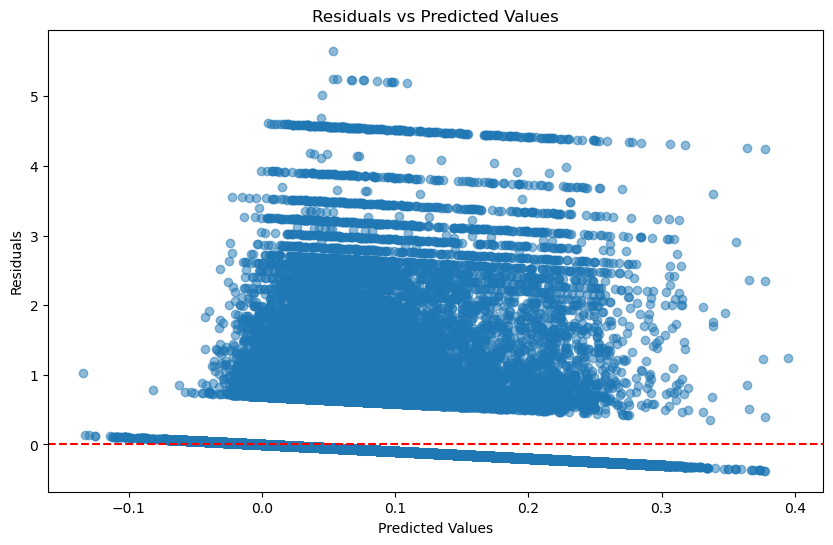

In [7]:
y_train_pred = best_model.predict(X_train)
residual_plot(y_true=y_train, y_pred=y_train_pred)

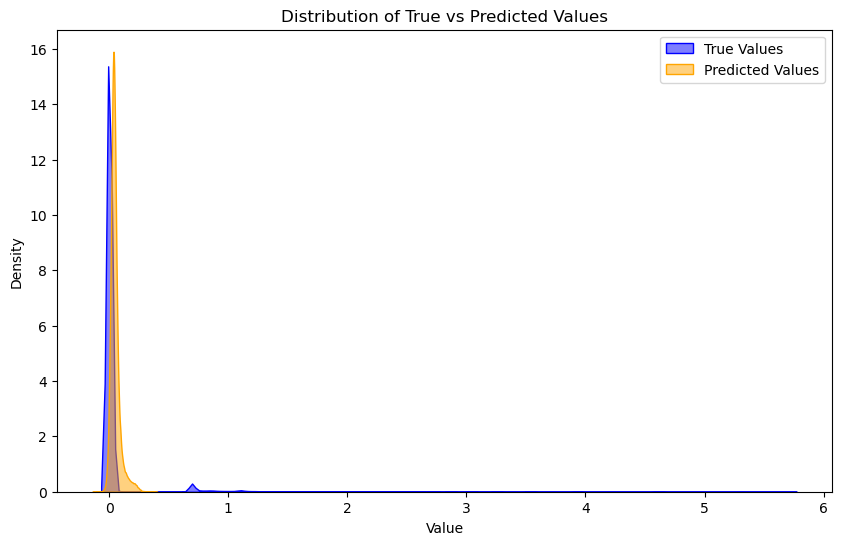

In [8]:
prediction_distribution(y_true=y_train, y_pred=y_train_pred)

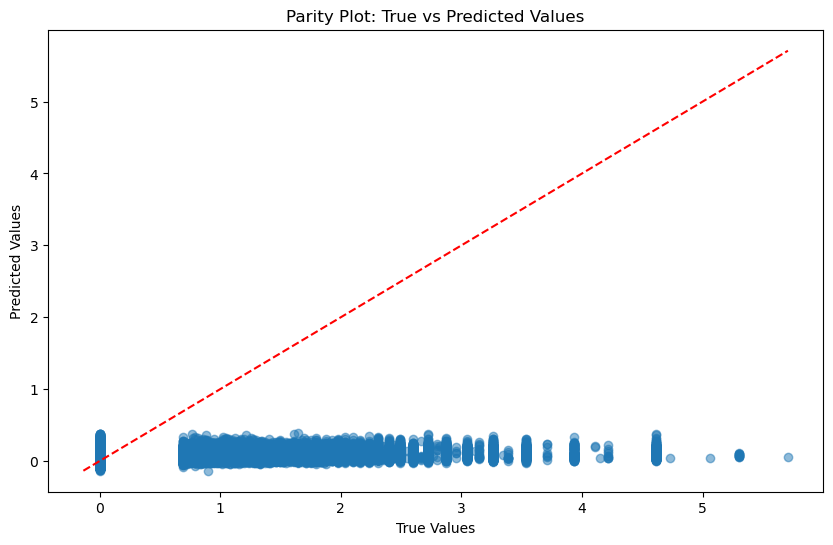

In [9]:
parity_plot(y_pred=y_train_pred, y_true=y_train)

In [10]:
plot_learning_curve(best_model, X_train, y_train)

TypeError: LearningCurveDisplay.from_estimator() got an unexpected keyword argument 'figsize'

### Evaluation 

Let's use our model on the test data.

In [14]:
y_test_pred = best_model.predict(X_test)

Plots:


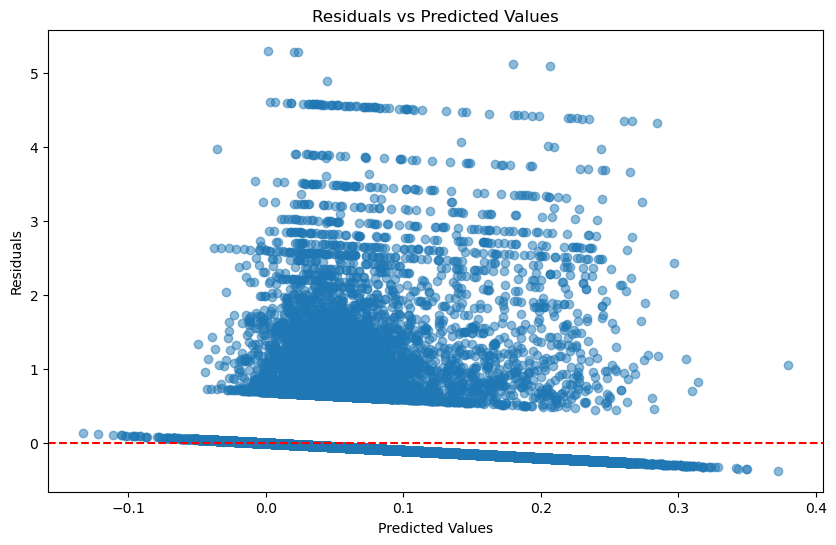

In [15]:
residual_plot(y_true=y_test, y_pred=y_test_pred)

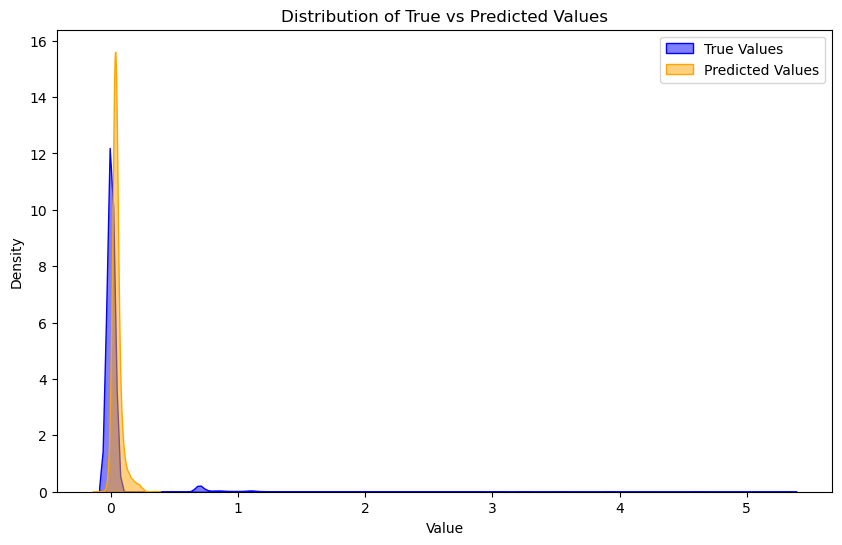

In [16]:
prediction_distribution(y_true=y_test, y_pred=y_test_pred)

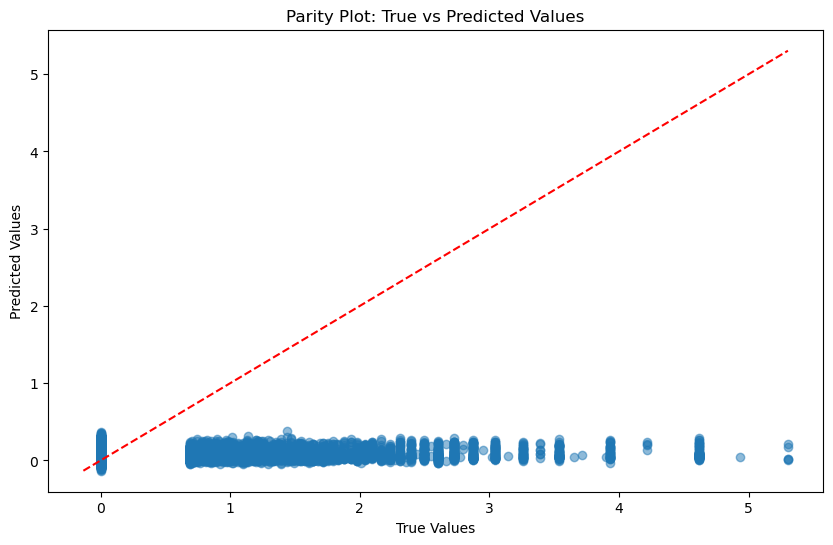

In [17]:
parity_plot(y_pred=y_test_pred, y_true=y_test)

### Saving the model

In [18]:
joblib.dump(best_model, "../models/best_mlp_scratch_model.joblib")

PicklingError: Can't pickle <function MLP.__init__.<locals>.<lambda> at 0x146704ea0>: it's not found as src.models.MLP_scratch.MLP.__init__.<locals>.<lambda>